## Packages

Let's run the cell below to import all the packages needed.


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib widget
import matplotlib.pyplot as plt
import VGG16utils


### Loading the data

In [27]:
X_train = np.load("savedData/150x150_propVal_aug_balanced/real/x_train.npy")
Y_train = np.load("savedData/150x150_propVal_aug_balanced/real/y_train.npy")
x_val=np.load("savedData/150x150_propVal_aug_balanced/real/x_val.npy") #cross validation data 
y_val=np.load("savedData/150x150_propVal_aug_balanced/real/y_val.npy") #cross validation data 
x_test=np.load("savedData/150x150_propVal_aug_balanced/real/x_test.npy") #test set image
y_test=np.load("savedData/150x150_propVal_aug_balanced/real/y_test.npy") #test set classification

### Visualisation

we can print the shape of each array

In [28]:
print("the shape of X_train is", X_train.shape)
print("the shape of y is", Y_train.shape)
print("x_small shape is", x_val.shape)
print("y_small shape is", y_val.shape)
print("x_test shape is", x_test.shape)
print("y_test shape is ", y_test.shape)

the shape of X_train is (8078, 100, 100, 1)
the shape of y is (8078,)
x_small shape is (50, 100, 100, 1)
y_small shape is (50,)
x_test shape is (624, 100, 100)
y_test shape is  (624,)


### VGG16
we now need to set up vgg16 and reprapre the data

In [29]:
#Be careful run only one this code otherwise adding too much dim or reload the code 2 row above
X_rgb = np.repeat(X_train[:, :,:, np.newaxis], 3, axis=3)
print("X_rgb shape is", X_rgb.shape)
x_val=np.repeat(x_val[:, :,:, np.newaxis], 3, axis=3)
x_test=np.repeat(x_test[:, :,:, np.newaxis], 3, axis=3)

X_train=X_rgb
inputShape=np.squeeze(X_train[0],axis=-1).shape

X_rgb shape is (8078, 100, 100, 3, 1)


In [30]:
vgg_layer = VGG16(weights='imagenet', include_top=False, input_shape=inputShape)
vgg_layer.trainable=False

## Convolutional Neural Network

we can now implement our CNN model

In [31]:
#code assignment starts here

VGG_model = Sequential((
    [
        (vgg_layer),
        (Flatten()),
        (Dense(units = 64 , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (Dense(units = 3 , activation = 'linear')) 
    ]
),name='CNN')

VGG_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #prefered way of implementing a softmax
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

#code assignment stops here

we can check our model's detail

In [32]:
VGG_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                294976    
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 15,009,859
Trainable params: 295,171
Non-trainable params: 14,714,688
_________________________________________________________________


We use a a function that stop when the val encounter a plateau in order to avoid overfittin

In [33]:
Reduce_LR = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Testing

we can then fit our model and our data


In [34]:
#code from the assignment start here:
history = VGG_model.fit(
    X_train,Y_train,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [early_stopping,Reduce_LR],
)

#end of the code from assignment

Epoch 1/12
 13/253 [>.............................] - ETA: 3:20 - loss: 9.3743 - accuracy: 0.4952

KeyboardInterrupt: 

### Metrics on train set

We can observe the metrics of the model

In [10]:
# Prediction on our training data
y_pred_train = VGG_model.predict(X_train)

#beginning of code from the assignment for softmax uses
prediction_p = tf.nn.softmax(y_pred_train)
y_pred_classes = np.argmax(prediction_p, axis=1)
#enf od code from assignment



In [11]:
print(classification_report(Y_train, y_pred_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , VGG_model.evaluate(X_train,Y_train)[0])
print("Accuracy of the model is - " , VGG_model.evaluate(X_train,Y_train)[1]*100 , "%")

                    precision    recall  f1-score   support

  Normal (Class 0)       0.87      0.96      0.91      2682
Bacteria (Class 1)       0.71      0.73      0.72      2698
   Viral (class 2)       0.72      0.62      0.66      2698

          accuracy                           0.77      8078
         macro avg       0.77      0.77      0.77      8078
      weighted avg       0.77      0.77      0.77      8078

253/253 [==============================] - 365s 1s/step - loss: 0.6179 - accuracy: 0.7706
Loss of the model is -  0.6179196238517761
253/253 [==============================] - 346s 1s/step - loss: 0.6179 - accuracy: 0.7706
Accuracy of the model is -  77.06115245819092 %


#### overfitting
We can plot the training accuracy and the validation accuracy to have a first idea of the overfitting of our model. If the Validation accuracy stops or decrease and the training one is increasing that might indicate case of overfitting the training set.
If the validation loss keep increasing and the training one keep decreasing that might suggest overfitting

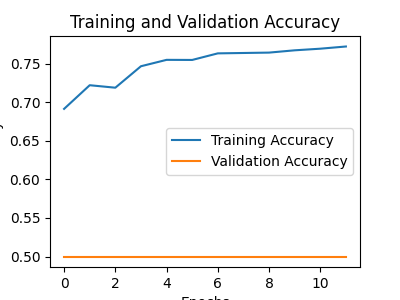

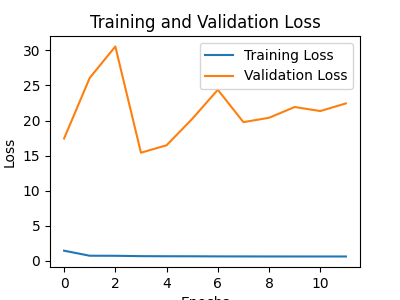

In [12]:
VGG16utils.plt_Training_Val_Accuracy(history)
VGG16utils.plt_Training_Val_loss(history)

### Prediction
we can now try our model on the test set


In [13]:
#prediction on the test set
y_pred_test=VGG_model.predict(x_test)

#beginning of code from the assignment for softmax uses
prediction = tf.nn.softmax(y_pred_test)
prediction_classes = np.argmax(prediction, axis=1)
#enf od code from assignment

#print partly of the result
print("the first ten classes are :", prediction_classes[:10])

the first ten classes are : [0 0 0 0 0 0 0 2 2 0]


### Analysis of the prediction

we can calculate the metrics of our prediction of the test set this time to have even more information of our model

                    precision    recall  f1-score   support

  Normal (Class 0)       0.64      0.90      0.75       234
Bacteria (Class 1)       1.00      0.03      0.06       242
   Viral (class 2)       0.32      0.61      0.42       148

          accuracy                           0.50       624
         macro avg       0.65      0.52      0.41       624
      weighted avg       0.70      0.50      0.40       624

20/20 [==============================] - 28s 1s/step - loss: 13.3376 - accuracy: 0.4968
Loss of the model is -  13.337624549865723
20/20 [==============================] - 28s 1s/step - loss: 13.3376 - accuracy: 0.4968
Accuracy of the model is -  49.67948794364929 %


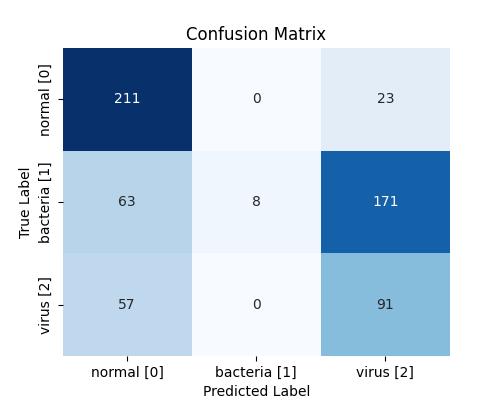

In [14]:
print(classification_report(y_test, prediction_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , VGG_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , VGG_model.evaluate(x_test,y_test)[1]*100 , "%")

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_classes)
VGG16utils.plt_conf_matrix(conf_matrix)


In [ ]:
VGG16utils.plot_roc_curve(y_test, prediction_classes, 3)